In [6]:
import json
import requests
from keras import optimizers
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer

import tensorflow as tf
from tensorflow.keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from tensorflow.keras.layers import Bidirectional, GlobalMaxPool1D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras import layers

sns.set_palette('Set2')
%matplotlib inline

In [7]:
df=pd.read_csv('../data/input_data/bitfinix.csv')
df.time = pd.to_datetime(df.time, unit='ms')

In [ ]:
df.head()

In [8]:
df = df.set_index('time')

In [3]:
def StochRSI(price, window=14):
    delta = price['close'].diff()
    upDays = delta.copy()
    upDays[delta<=0]=0.0
    downDays = abs(delta.copy())
    downDays[delta>0]=0.0
    

    RolUp = upDays.rolling(window).mean()
    RolDown = downDays.rolling(window).mean()

    RS = RolUp / RolDown

    rsi= 100.0 - (100.0 / (1.0 + RS))
    stochrsi  = (rsi - rsi.rolling(window).min()) / (rsi.rolling(window).max() - rsi.rolling(window).min())
    return stochrsi

In [4]:
SRSI = StochRSI(df)

In [5]:
df['SRSI'] = SRSI

In [4]:
#df['Date'] = pd.to_datetime(df['Date'], format="%Y-%m-%d" )
#df['time'] = df.Date.astype(str) + df['Timestamp']
#df = df.set_index('time')
df.head()


,open,close,high,low,volume
time,,,,,
2013-04-01 00:07:00,93.25,93.30,93.30,93.25,93.300000
2013-04-01 00:08:00,100.00,100.00,100.00,100.00,93.300000
2013-04-01 00:09:00,93.30,93.30,93.30,93.30,33.676862
2013-04-01 00:11:00,93.35,93.47,93.47,93.35,20.000000
2013-04-01 00:12:00,93.47,93.47,93.47,93.47,2.021627


In [9]:
df.tail()

,open,close,high,low,volume
time,,,,,
2019-09-01 12:05:00,9599.2,9599.2,9599.2,9599.2,0.157067
2019-09-01 12:06:00,9599.2,9599.3,9599.3,9599.2,0.451362
2019-09-01 12:07:00,9599.3,9599.3,9599.3,9599.2,0.881811
2019-09-01 12:08:00,9599.2,9599.2,9599.2,9599.2,0.495040
2019-09-01 12:09:00,9599.2,9599.2,9599.2,9599.2,0.187724


In [7]:
print(np.isnan(df).sum())

close          0
high           0
low            0
open           0
volumefrom     0
volumeto       0
SRSI          27
dtype: int64


In [33]:
print(df.shape)

(2001, 7)


In [6]:
df.dropna(inplace=True)

In [9]:
print(np.isnan(df).sum())

close         0
high          0
low           0
open          0
volumefrom    0
volumeto      0
SRSI          0
dtype: int64


In [10]:
split_row = len(df) - int(0.2 * len(df))
train_data = df.iloc[:split_row]
test_data = df.iloc[split_row:]

In [10]:
split_row

1931695

In [11]:
ind=df[1931696:2414618].index.tolist()

In [7]:
len(df)

2414618

In [23]:
train_data.head()

,high,low,open,volume
time,,,,
2013-04-01 00:07:00,93.30,93.25,93.25,93.300000
2013-04-01 00:08:00,100.00,100.00,100.00,93.300000
2013-04-01 00:09:00,93.30,93.30,93.30,33.676862
2013-04-01 00:11:00,93.47,93.35,93.35,20.000000
2013-04-01 00:12:00,93.47,93.47,93.47,2.021627


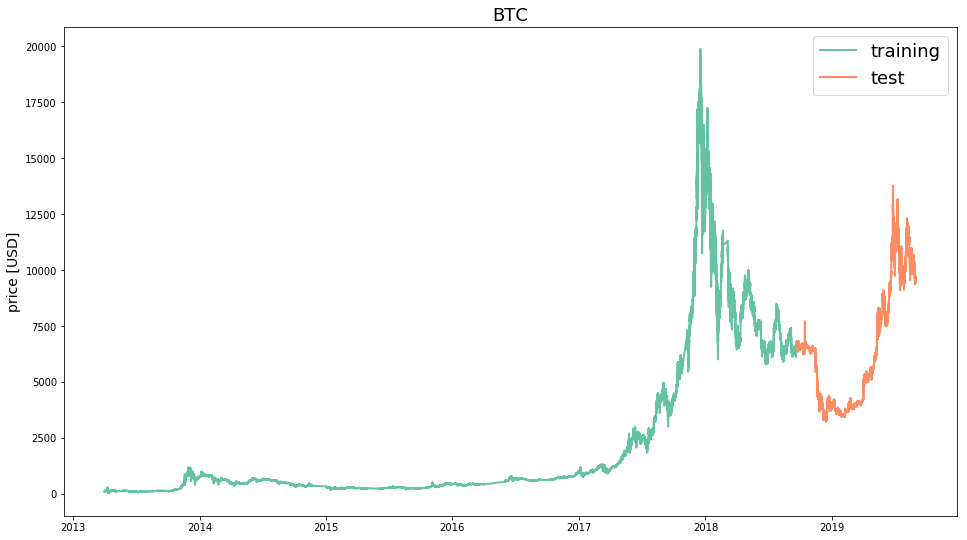

In [206]:
fig, ax = plt.subplots(1, figsize=(16, 9))
#ax.plot(train_data['close'], label='training', linewidth=2)
#ax.plot(test_data['close'], label='test', linewidth=2)

ax.plot(train_data['close'], label='training', linewidth=2)
ax.plot(test_data['close'], label='test', linewidth=2)

ax.set_ylabel('price [USD]', fontsize=14)
ax.set_title('BTC', fontsize=18)
ax.legend(loc='best', fontsize=18);

In [12]:
x_train = train_data[['high','low','open','volume']]
y_train = train_data[['close']]
x_test = test_data[['high','low','open','volume']]
y_test = test_data[['close']]


In [7]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
scaler1 = MinMaxScaler(feature_range=(0, 1))
x_train = scaler.fit_transform(x_train)
y_train = scaler1.fit_transform(y_train)
x_test = scaler.transform(x_test)
y_test = scaler1.transform(y_test)

In [19]:
from sklearn.externals import joblib
scaler_filename = "scaler.save"
joblib.dump(scaler, scaler_filename) 



/home/divya_kaushik1010/.local/lib/python3.5/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


['scaler.save']

In [20]:
scaler_filename = "scaler1.save"
joblib.dump(scaler1, scaler_filename) 



['scaler1.save']

In [24]:
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

ValueError: Must pass 2-d input

In [19]:
#inputShape=(x_train.shape[1], x_train.shape[2])
print(x_train.shape)

(1931695, 4)


In [16]:
#check for GPU flow
print(tf.__version__)
x = tf.random.uniform([3, 3])
print(tf.test.is_gpu_available())
print("Is the Tensor on GPU #0:  "),
print(x.device.endswith('GPU:0'))

print("Device name: {}",format((x.device)))
print(tf.keras.__version__)

2.0.0-rc1
True
Is the Tensor on GPU #0:  
True
Device name: {} /job:localhost/replica:0/task:0/device:GPU:0
2.2.4-tf


In [21]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(20, input_shape = (x_train.shape[1], x_train.shape[2]))))
model1.add(Dropout(0.25))
adam= tf.keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=True)
sgd = tf.keras.optimizers.SGD(lr=0.001, momentum=0.99, decay=0.0, nesterov=True)
rmsprop = tf.keras.optimizers.RMSprop(lr=0.001, rho=0.99, epsilon=None, decay=0.0)
model1.add(Dense(1, activation='relu'))
model1.compile(loss='mae', optimizer=adam, metrics=['accuracy', 'mse', 'mae'])
model1.fit(x_train, y_train, batch_size=15000, epochs=20, validation_data=(x_test, y_test), verbose = 1)
model1.summary()

ValueError: Please provide as model inputs either a single array or a list of arrays. You passed: inputs=                            high         low         open      volume
time                                                                 
2013-04-01 00:07:00    93.300000    93.25000    93.250000   93.300000
2013-04-01 00:08:00   100.000000   100.00000   100.000000   93.300000
2013-04-01 00:09:00    93.300000    93.30000    93.300000   33.676862
2013-04-01 00:11:00    93.470000    93.35000    93.350000   20.000000
2013-04-01 00:12:00    93.470000    93.47000    93.470000    2.021627
2013-04-01 00:13:00    93.030010    93.03000    93.030010    4.985400
2013-04-01 00:26:00    93.043990    93.04399    93.043990   12.689501
2013-04-01 00:28:00    93.350000    93.34999    93.349990    5.000000
2013-04-01 00:35:00    93.350000    93.19999    93.199990   40.000000
2013-04-01 00:53:00    93.300000    93.25000    93.250000   18.300000
2013-04-01 00:54:00    93.100000    93.10000    93.100000   22.310499
2013-04-01 01:00:00    93.379990    93.37999    93.379990    0.135403
2013-04-01 01:06:00    93.380010    93.37999    93.380010    3.409091
2013-04-01 01:07:00    93.379990    93.37999    93.379990    5.109091
2013-04-01 01:11:00    93.480010    93.37999    93.480010    3.982734
2013-04-01 01:12:00    93.487970    93.20000    93.480010    9.814407
2013-04-01 01:13:00    93.487970    93.48797    93.487970    1.059883
2013-04-01 01:23:00    93.484700    93.48470    93.484700   16.060000
2013-04-01 01:28:00    93.400010    93.40001    93.400010    3.400000
2013-04-01 01:36:00    93.100010    93.10000    93.100010    2.272727
2013-04-01 02:05:00    93.170000    93.17000    93.170000    0.627600
2013-04-01 02:08:00    93.290000    93.16999    93.169990   10.000000
2013-04-01 02:27:00    93.109990    93.10999    93.109990    0.433820
2013-04-01 02:36:00    93.240000    93.24000    93.240000    1.250000
2013-04-01 02:38:00    93.500000    93.47800    93.478000  200.000000
2013-04-01 02:40:00    93.500000    93.50000    93.500000  200.000000
2013-04-01 02:41:00    93.500000    93.50000    93.500000   30.000000
2013-04-01 02:43:00    94.000000    93.53001    93.530010   12.000000
2013-04-01 02:44:00    93.640000    93.64000    93.640000   10.000000
2013-04-01 02:52:00    93.740000    93.74000    93.740000    2.000000
...                          ...         ...          ...         ...
2018-09-23 02:34:00  6703.000000  6702.70000  6703.000000    0.093225
2018-09-23 02:35:00  6701.200000  6701.10000  6701.100000    0.601612
2018-09-23 02:36:00  6701.200000  6701.10000  6701.200000    0.915778
2018-09-23 02:37:00  6701.000000  6700.00000  6701.000000    0.062519
2018-09-23 02:38:00  6700.800000  6700.00000  6700.100000    0.899216
2018-09-23 02:39:00  6700.700000  6700.70000  6700.700000    0.015308
2018-09-23 02:40:00  6700.700000  6700.60000  6700.600000    0.371020
2018-09-23 02:41:00  6700.700000  6700.00000  6700.700000    8.130422
2018-09-23 02:42:00  6701.100000  6700.40000  6700.400000    0.164514
2018-09-23 02:43:00  6701.100000  6701.00000  6701.000000    0.258771
2018-09-23 02:44:00  6701.100000  6701.00000  6701.100000    0.056000
2018-09-23 02:45:00  6702.000000  6701.90000  6701.900000    0.042338
2018-09-23 02:46:00  6702.000000  6701.90000  6701.900000    0.023000
2018-09-23 02:47:00  6702.000000  6701.90000  6702.000000    0.620683
2018-09-23 02:48:00  6708.400000  6701.80000  6701.900000   45.394484
2018-09-23 02:49:00  6707.600000  6707.50000  6707.500000    0.202149
2018-09-23 02:50:00  6707.600000  6707.50000  6707.600000    0.038427
2018-09-23 02:51:00  6707.600000  6707.50000  6707.600000    0.017239
2018-09-23 02:52:00  6707.500000  6707.50000  6707.500000    0.143000
2018-09-23 02:53:00  6707.600000  6707.50000  6707.600000    0.356000
2018-09-23 02:54:00  6707.600000  6707.50000  6707.600000    0.208092
2018-09-23 02:55:00  6707.500000  6707.50000  6707.500000    0.117462
2018-09-23 02:56:00  6707.600000  6705.70000  6707.600000    3.585477
2018-09-23 02:57:00  6705.200000  6705.10000  6705.100000    0.033434
2018-09-23 02:58:00  6705.100000  6705.10000  6705.100000    2.264782
2018-09-23 02:59:00  6705.187988  6700.90000  6705.187988    1.097974
2018-09-23 03:00:00  6700.500000  6700.10000  6700.500000    6.128679
2018-09-23 03:01:00  6700.200000  6700.10000  6700.100000    0.218877
2018-09-23 03:02:00  6700.200000  6700.10000  6700.200000   11.535025
2018-09-23 03:03:00  6700.200000  6700.10000  6700.100000    1.100875

[1931695 rows x 4 columns]

In [138]:
model.save('model.h5')

In [222]:
#preds = model.predict(x_test)
preds = model1.predict(x_test)

In [223]:
from math import sqrt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
print("Root Mean Squared Error(RMSE) : ", sqrt(mean_squared_error(y_test,preds)))
print("Mean Absolute Error(MAE) : ", mean_absolute_error(y_test,preds))
r2 =  r2_score(y_test, preds)
print("R Squared (R2) : ",r2)



Root Mean Squared Error(RMSE) :  0.0009590611480093646
Mean Absolute Error(MAE) :  0.0008322022860956813
R Squared (R2) :  0.999949523674659


In [224]:
n = len(x_train)
p = len(x_train[0])
num = (1-r2)*(n-1)
denom = (n-p-1)
r2_adj = 1-(num/denom)
print("Adjusted R2 : ",r2_adj)

Adjusted R2 :  0.9999495236485283


In [225]:
y_inv=scaler1.inverse_transform(y_test).tolist()

In [226]:
y_list = [item for sublist in y_inv for item in sublist]

In [227]:
pred_lst=scaler1.inverse_transform(preds).tolist()

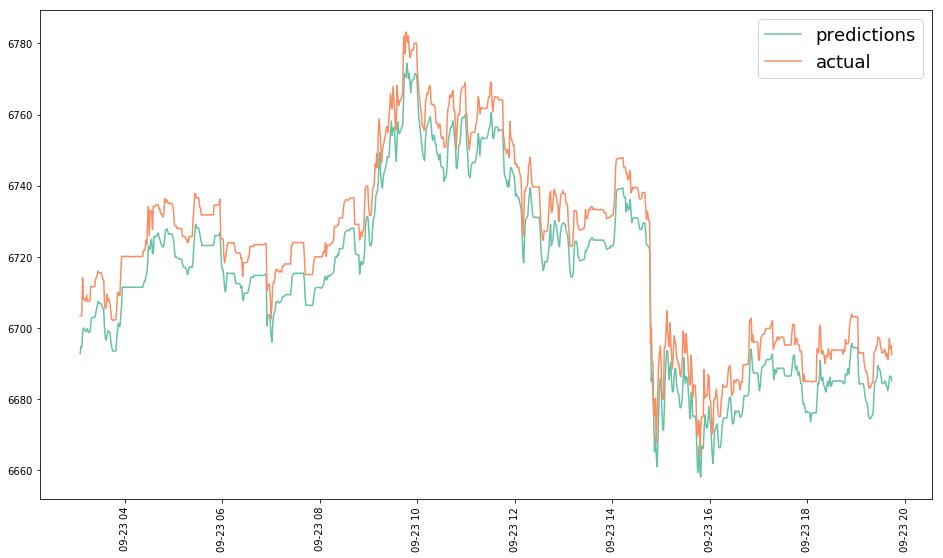

In [228]:
fig, ax = plt.subplots(1, figsize=(16, 9))
ax.plot(ind[0:1000],pred_lst[0:1000],label='predictions')
ax.plot(ind[0:1000],y_list[0:1000],label='actual')
ax.legend(loc='best', fontsize=18)
plt.xticks(rotation=90)
plt.show()